##Gerekli Kütüphaneleri Kurmak


In [ ]:
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random , os , glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

#warningleri kapatmak için
import warnings
warnings.filterwarnings('ignore')

#Model değerleendirmek için kullanılacak kütüphane
from sklearn.metrics import confusion_matrix , classification_report

#Model İçin Kullanılacak Kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Conv2D , Flatten , MaxPooling2D , Dense , Dropout , SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array , load_img , array_to_img
from keras.utils import to_categorical

##Veri Okuma

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/Garbage classification'

In [ ]:
#Target Size ve Label Etiketlerin Belirlenmesi
target_size = (224,224)
waste_labels = {'cardboard':0,'glass':1,'metal':2,'paper':3,'plastic':4,'trash':5}

In [ ]:
def load_datasets(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path)))
  print(image_paths)
  for image_path in image_paths:
    #Belirtilen Görüntüleri Open CV İle Oku
    img = cv2.imread(image_path)

    #Okunan görüntüleri başlangıçta belirlenen target_sizea göre yeniden ölçeklendir
    img = cv2.resize(img , target_size)

    #ölçeklendirilen görüntüyü x listesine ekle
    x.append(img)

    #Her bir path '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı labelı temsil etmektedir
    label = image_path.split(os.path.sep)[-2]

    #yakalanan labelların sayısal değer karşılıklarının olduğu waste_labels sözlüğü içersinden gönderilen key
    #değerine karşılık value değeri alınarak label oluşturulur
    labels.append(waste_labels[label])

  #veri seti random bir sekilde karıştırılır
  x , labels = shuffle(x,labels,random_state=42)

  #boyut ve sınıf bilgisi raporlanmaktadır
  print(f"X boyutu:{np.array(x).shape}")
  print(f"label sınıf sayısı:{len(np.unique(labels))} Gözlem Sayısı:{len(labels)}")

  return x, labels

In [ ]:
x,labels = load_datasets(dir_path)

['/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard1.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard10.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard100.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard101.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard102.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard103.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard104.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard105.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard106.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard107.jpg', '/content/drive/MyDrive/Colab Notebooks/Garbage classification/cardboard/cardboard

In [ ]:
 input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
 print(input_shape)

(224, 224, 3)


##Veri Setinden Örnek Görmek

In [ ]:
def visualize_img(image_batch , label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels,num_classes=6)[n]==1][0].title())
    plt.axis("off")

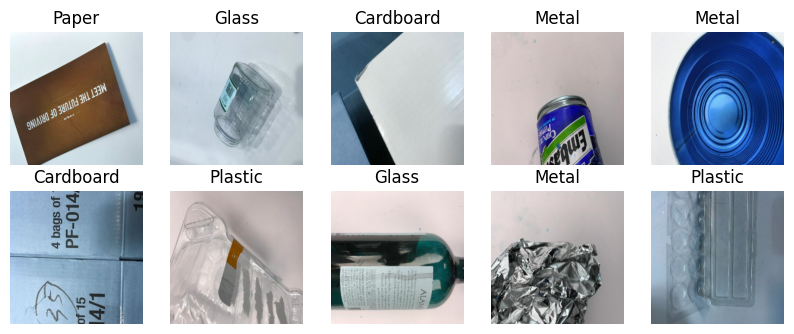

In [ ]:
visualize_img(x,labels)

#Veriyi Hazırlama

In [ ]:
#Train veri seti için bir generator tanımlıyoruz. ==> Kırpma , döndürme bölme , gürültü ekleme , modelin aşırı uyum önler

train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1, #Eğim Vermek
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)
#Test verisi için generator Tanımlama
test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [ ]:



train_generator = train.flow_from_directory(directory=dir_path,
    target_size=(target_size),
    class_mode='categorical',
    subset='training'
)

test_generator = test.flow_from_directory(
    directory=dir_path,
    target_size=(target_size),
    batch_size=251,
    class_mode='categorical',
    subset='validation'
)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [ ]:
#Modelin Kurulması
from keras.api._v2.keras import activations
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', input_shape=(input_shape), activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

model.add(Flatten())
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=32, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units=6, activation='softmax'))

NameError: ignored

In [ ]:
from keras.mixed_precision.loss_scale_optimizer import optimizer
#Optimasyon Metriklerin Ayarlanması



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),"acc"])


In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',patience=50,verbose=1,mode="min"),
             ModelCheckpoint(filepath='mymodel.h5',monitor='val_loss',mode='min',save_best_only=True,save_weights_only=False,verbose=1)]

In [ ]:
#Modelin Eğitilmesi

# Modeli eğitme
history = model.fit(train_generator,
                    epochs=100,
                    validation_data=test_generator,
                    callbacks=callbacks,
                    workers=4,
                    steps_per_epoch=2276//32,
                    validation_steps=251//32)






Text(0.5, 1.0, 'Training and Validation Loss')

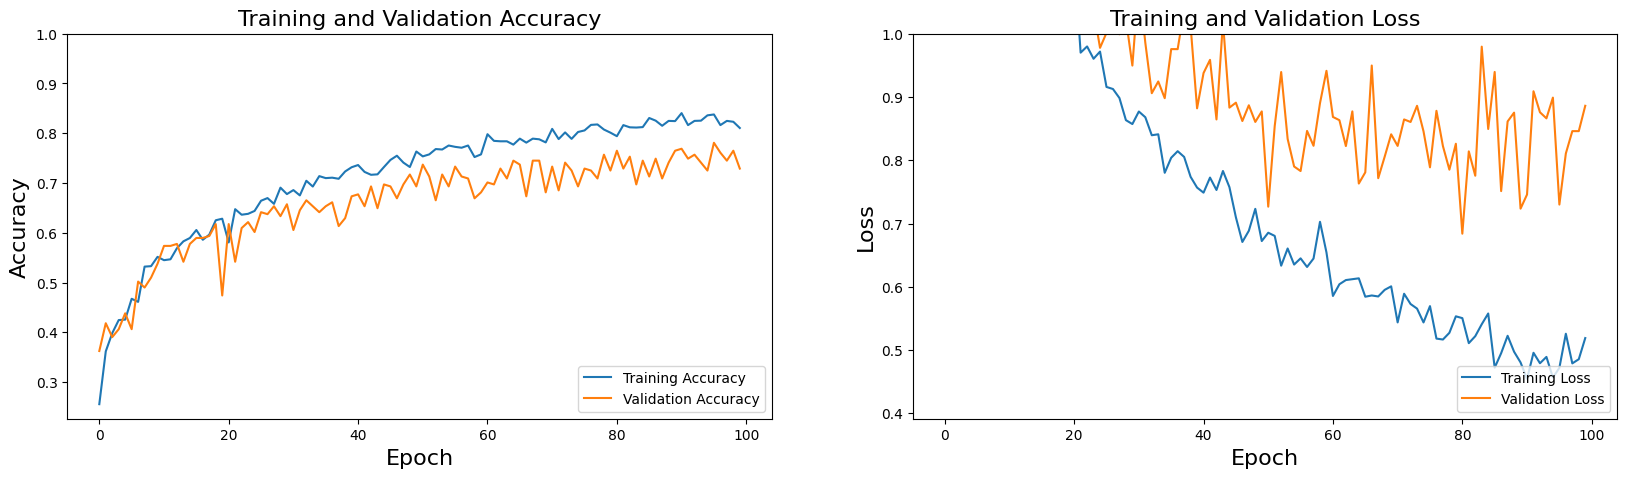

In [ ]:
#------------------------
#Accuracy Grafik
#------------------------

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history['acc'],label='Training Accuracy')
plt.plot(history.history['val_acc'],label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy',fontsize=16)


#------------------------
#Loss Grafik
#------------------------

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Loss',fontsize=16)

In [ ]:
loss,precision , recall,acc = model.evaluate(test_generator,batch_size=32)

print("\nTest accuracy: %.1f%%" %(100.0*acc)) # Doğru Sınıflandırma Oranı
print("\nTest loss: %.1f%%" %(100.0*loss))
print("\nTest precision: %.1f%%" %(100.0*precision)) #Tahmin Edilenlerin Ne kadar Başarılı Olduğu
print("\nTest recall: %.1f%%" %(100.0*recall)) # gercek Değerleri Ne kadar doğru tahmin ettik

1/1 [==============================] - 1s 998ms/step - loss: 0.8861 - precision: 0.7682 - recall: 0.6733 - acc: 0.7291

Test accuracy: 72.9%

Test loss: 88.6%

Test precision: 76.8%

Test recall: 67.3%


In [ ]:
#Classification Report
x_test , y_test = test_generator.next()

y_pred = model.predict(x_test);

y_pred = np.argmax(y_pred,axis=1)
y_test = np.argmax(y_test,axis=1)

target_names = list(waste_labels.keys())

print(classification_report(y_test,y_pred,target_names=target_names))

8/8 [==============================] - 0s 19ms/step
              precision    recall  f1-score   support

   cardboard       0.87      0.68      0.76        40
       glass       0.69      0.74      0.71        50
       metal       0.60      0.73      0.66        41
       paper       0.80      0.97      0.88        59
     plastic       0.81      0.54      0.65        48
       trash       0.46      0.46      0.46        13

    accuracy                           0.73       251
   macro avg       0.71      0.69      0.69       251
weighted avg       0.74      0.73      0.72       251



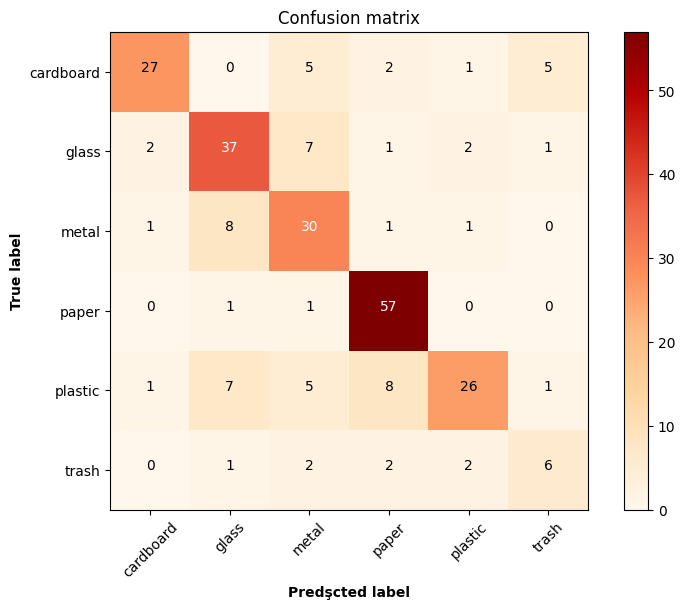

In [ ]:
cm = confusion_matrix(y_test,y_pred)

def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap=plt.cm.Blues):
  if normalize:
    cm=cm.astype('float')/cm.sım(axis=1)[:,np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() /2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment='center',
             color='white' if cm[i,j]>thresh else 'black')
  plt.tight_layout()
  plt.ylabel('True label',fontweight="bold")
  plt.xlabel("Predşcted label",fontweight="bold")

plot_confusion_matrix(cm,waste_labels.keys(),
                      title='Confusion matrix',
                      cmap=plt.cm.OrRd)

In [ ]:
def model_testing(path):
  img = image.load_img(path,target_size=(target_size))
  img = image.img_to_array(img,dtype=np.uint8)
  img=np.array(img)/255.0
  p=model.predict(img.reshape(1,224,224,3))
  predicted_class = np.argmax(p[0])

  return img , p , predicted_class


img1 , p1 , predicted_class1 = model_testing(dir_path+'/metal/metal100.jpg')
img2 , p2 , predicted_class2 = model_testing(dir_path+'/glass/glass105.jpg')
img3 , p3 , predicted_class3 = model_testing(dir_path+'/cardboard/cardboard103.jpg')
img4 , p4 , predicted_class4 = model_testing(dir_path+'/paper/paper101.jpg')

1/1 [==============================] - 0s 33ms/step


In [ ]:
waste_labels = {0:'cardboard',1:'glass',2:'metal',3:'paper',4:'plastic',5:'trash'}

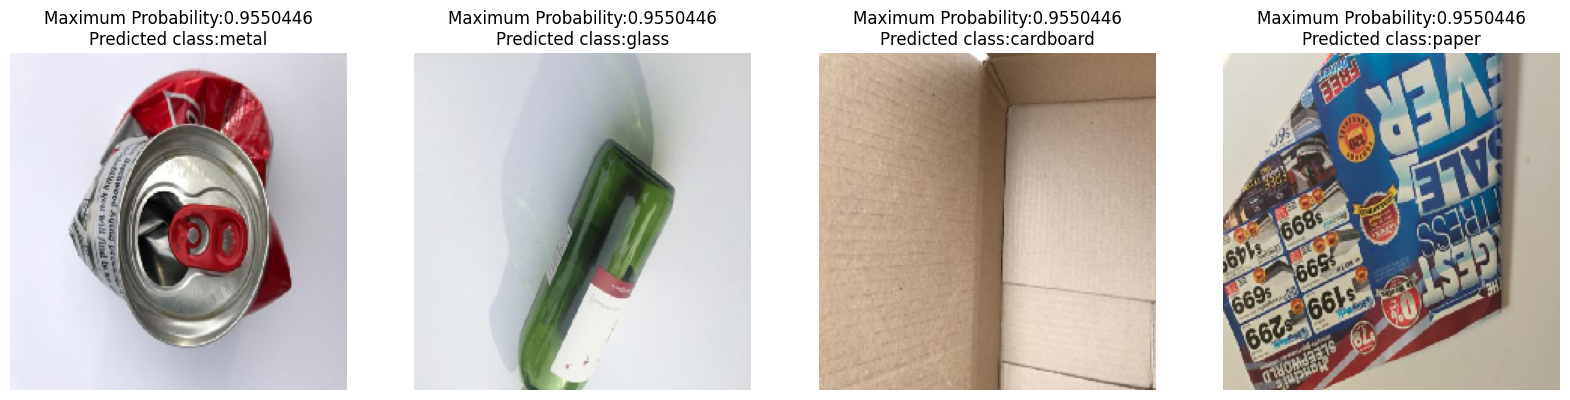

In [ ]:
plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability:"+str(np.max(p1[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability:"+str(np.max(p1[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class2]))
plt.imshow(img2);

plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title("Maximum Probability:"+str(np.max(p1[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class3]))
plt.imshow(img3);


plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title("Maximum Probability:"+str(np.max(p1[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class4]))
plt.imshow(img4);